<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 02 — Deep Q-Learning (Keras 3 with PyTorch Backend)**

© Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**Adapted for Keras 3 API with PyTorch backend**

## CartPole

### The Game Environment

In [1]:
import gymnasium as gym

In [2]:
env = gym.make('CartPole-v1')

In [3]:
env.action_space

Discrete(2)

In [4]:
env.action_space.n

np.int64(2)

In [5]:
[env.action_space.sample() for _ in range(10)]

[np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0)]

In [6]:
env.observation_space

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

In [7]:
env.observation_space.shape

(4,)

In [8]:
env.reset(seed=100)
# cart position, cart velocity, pole angle, pole angular velocity

(array([ 0.03349816,  0.0096554 , -0.02111368, -0.04570484], dtype=float32),
 {})

In [9]:
env.step(0)

(array([ 0.03369127, -0.18515752, -0.02202777,  0.24024247], dtype=float32),
 1.0,
 False,
 False,
 {})

In [10]:
env.step(1)

(array([ 0.02998812,  0.01027205, -0.01722292, -0.05930644], dtype=float32),
 1.0,
 False,
 False,
 {})

In [11]:
class RandomAgent:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
    def play(self, episodes=1):
        self.trewards = list()
        for e in range(episodes):
            self.env.reset()
            for step in range(1, 100):
                a = self.env.action_space.sample()
                state, reward, done, trunc, info = self.env.step(a)
                if done:
                    self.trewards.append(step)
                    break

In [12]:
ra = RandomAgent()

In [13]:
ra.play(15)

In [14]:
ra.trewards

[13, 22, 24, 16, 19, 15, 14, 17, 24, 15, 13, 11, 29, 33, 10]

In [15]:
round(sum(ra.trewards) / len(ra.trewards), 2)

18.33

### Setup Keras 3 with PyTorch Backend

In [16]:
import os
import random
import warnings
import numpy as np

# Configure Keras to use PyTorch backend
os.environ['KERAS_BACKEND'] = 'torch'

import keras
from keras import layers, models, optimizers, ops
from collections import deque

print(f"Using Keras {keras.__version__} with backend: {keras.backend.backend()}")

Using Keras 3.11.3 with backend: torch


In [17]:
warnings.simplefilter('ignore')
os.environ['PYTHONHASHSEED'] = '0'

In [18]:
lr = 0.001

In [19]:
random.seed(100)
np.random.seed(100)
keras.utils.set_random_seed(100)

### DQL Agent with Keras 3 API

In [20]:
class DQLAgent:
    def __init__(self):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.9
        self.trewards = []
        self.max_treward = 0
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.model = self._create_model()
    
    def _create_model(self):
        """Create neural network using Keras 3 Sequential API"""
        model = models.Sequential([
            layers.Dense(24, activation='relu', input_shape=(self.state_size,)),
            layers.Dense(24, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        
        # Compile model with Adam optimizer and MSE loss
        model.compile(
            optimizer=optimizers.Adam(learning_rate=lr),
            loss='mse'
        )
        
        return model

In [21]:
class DQLAgent(DQLAgent):
    def act(self, state):
        """Epsilon-greedy action selection"""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        # Use Keras predict API
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def replay(self):
        """Experience replay using Keras 3 training API"""
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from memory
        batch = random.sample(self.memory, self.batch_size)
        
        # Prepare batch data
        states = np.array([x[0][0] for x in batch])
        actions = np.array([x[1] for x in batch])
        next_states = np.array([x[2][0] for x in batch])
        rewards = np.array([x[3] for x in batch])
        dones = np.array([x[4] for x in batch])
        
        # Predict Q-values for current states and next states
        q_values = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)
        
        # Update Q-values using Bellman equation
        for i in range(self.batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                q_values[i, actions[i]] = rewards[i] + self.gamma * np.amax(next_q_values[i])
        
        # Train model using Keras fit API
        self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=self.batch_size)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [22]:
class DQLAgent(DQLAgent):
    def learn(self, episodes):
        """Train the agent over multiple episodes"""
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            
            for f in range(1, 5000):
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                
                # Store experience in memory
                self.memory.append([state, action, next_state, reward, done])
                state = next_state
                
                if done or trunc:
                    self.trewards.append(f)
                    self.max_treward = max(self.max_treward, f)
                    templ = f'episode={e:4d} | treward={f:4d}'
                    templ += f' | max={self.max_treward:4d}'
                    print(templ, end='\r')
                    break
            
            # Experience replay after each episode
            if len(self.memory) > self.batch_size:
                self.replay()
        
        print()

In [23]:
class DQLAgent(DQLAgent):
    def test(self, episodes):
        """Test the trained agent"""
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            
            for f in range(1, 5001):
                # Use model prediction for action (no exploration)
                q_values = self.model.predict(state, verbose=0)
                action = np.argmax(q_values[0])
                
                state, reward, done, trunc, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size])
                
                if done or trunc:
                    print(f, end=' ')
                    break

### Training the DQL Agent

In [24]:
agent = DQLAgent()

In [25]:
%time agent.learn(2500)

episode=2500 | treward=  49 | max= 401
CPU times: total: 35.7 s
Wall time: 2min 42s


In [26]:
agent.epsilon

0.09997053357470892

### Testing the Trained Agent

In [27]:
agent.test(15)

124 56 61 69 91 52 59 69 55 131 58 101 69 96 55 

### Visualize Training Progress

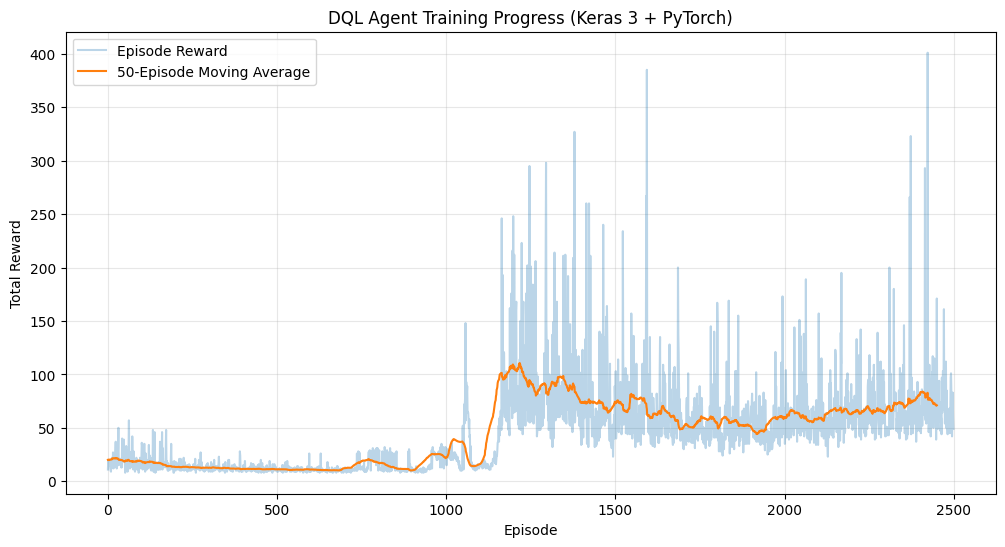

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(agent.trewards, alpha=0.3, label='Episode Reward')
plt.plot(np.convolve(agent.trewards, np.ones(50)/50, mode='valid'), label='50-Episode Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQL Agent Training Progress (Keras 3 + PyTorch)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Save/Load Model (Keras 3 API)

In [29]:
# Save model using Keras 3 API
agent.model.save('dql_cartpole_keras3.keras')

In [30]:
# Load model using Keras 3 API
# loaded_model = keras.models.load_model('dql_cartpole_keras3.keras')

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>